In [1]:
# Imports
from src.json_utils import read_jsonl
from src.config import DATA_DIR
import pandas as pd
import os

In [2]:
data = read_jsonl('../data/dkpol_tweets.jsonl')

Reading ../data/dkpol_tweets.jsonl


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69900 entries, 0 to 69899
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timestamp  69900 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1)
memory usage: 546.2 KB


/Users/hrmussa/.pyenv/versions/3.8.9/envs/ditw/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<AxesSubplot:xlabel='timestamp'>

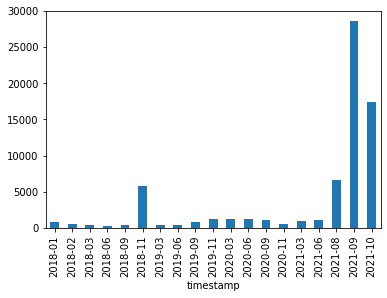

In [3]:
df = pd.DataFrame([i['created_at'] for i in data], columns=['timestamp'])
df.timestamp = pd.to_datetime(df.timestamp)
df.info()
df['timestamp'].groupby(df.timestamp.dt.to_period("M")).agg('count').plot(kind='bar')